In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.linear_model as sklm
import pywt

from scipy.fftpack import fft, fftfreq, ifft

class Simulator:
    
    kb = 1.308064e-23 # Boltzmann constant
    
    def __init__(self):
        pass
    
    def configure_experiment(self, 
                             lambda_lazer = 650e-9,
                             temperature = 273.15,
                             theta = np.pi / 3,
                             n = 1.33,
                             eta = 0.958e-3):
        
        self.lambda_lazer = lambda_lazer
        self.temperature = temperature
        self.theta = theta
        self.n = n
        self.eta = eta
        
        #Evaluate coefficient
        self.coeff = 2*(Simulator.kb * self.temperature/(3 * np.pi * self.eta)) * (4 * np.pi * self.n / self.lambda_lazer)**2 * np.sin(self.theta / 2)**2
    
    
    def get_lorentz(self, diameter, freq):
        if diameter == 0:
            raise ValueError('zero passed as a diameter')
        
        G = self.coeff / diameter
        
        # QUESTION: Do we really need (1 / pi) here?
        return 1 / np.pi * G / ((2 * np.pi * freq)**2 + G**2)
    

    def generate(self,
                 particle_diameters = np.array([100e-9]),
                 noise_level = 0.0,
                 time_series_size = 2**10,
                 f_s = 8000,
                 num_frequencies = 2**19 + 1):
        
        frequencies = np.linspace(0, f_s / 2, num_frequencies)
        
        initial_phases = np.random.uniform(0, 2 * np.pi, num_frequencies)
        
        time_series = np.linspace(0, time_series_size, time_series_size * f_s)
        
        ideal_lorentz = self.get_lorentz(particle_diameters[0], frequencies)
        amplitudes = np.sqrt(ideal_lorentz)
        
        get_x_ti = lambda t: sum(amplitudes * np.sin(2 * np.pi * frequencies * t))
        x_t = np.array(list(map(get_x_ti, time_series)))
        
        intensities = x_t**2
        
        return (intensities, time_series)
        
    

    def run_simulation(self, 
                       particle_diameters = np.array([38e-9]),
                       noise_level = 0.0,
                       time_series_size = 2**10,
                       f_generation = 50,
                       max_freq_value = 5514.0,
                       num_frequencies = 2**12):
        
        # x(t_i) = SUM_k^n [ sqrt(S(f_k)) * sin(2pi * f_k * t_i + phi_k)} ]
        
        # Generate @num_frequencies random frequencies uniformly distributed in the range [0, @max_freq_value]
        random_frequencies = np.random.uniform(0, max_freq_value, num_frequencies)
        
        # Generate @num_frequencies random initial phases (phi_k) uniformly distributed in the range [0, 2pi]
        initial_phases = np.random.uniform(0, 2 * np.pi, num_frequencies)
        
        # Create @time_series_size consecutive time values 0, 1, 2, ... , @time_series_size - 1
        
        time_series = np.linspace(0, time_series_size, time_series_size * f_generation)
        
        
        # Ideal lorentz S(f) = S[d1](f) + ... + S[dN](f)
        # Get an ideal amplitude SQRT(S(f)) for each random frequency (f_k) so as to obtain all SQRT[S(f_k)]
        ideal_lorentz = sum([self.get_lorentz(d, random_frequencies) for d in particle_diameters])
        ideal_amplitudes = np.sqrt(ideal_lorentz)
        
        
        # Obtain x(time_series)
        get_x_ti = lambda t: sum(ideal_amplitudes * np.sin(2 * np.pi * random_frequencies * t + initial_phases))
        x_t = np.array(list(map(get_x_ti, time_series)))
        
        # Do normalization {x(t) - min(x(t))} so as to have positive (ala-experimental) values (refer to the article)
        min_x_t = min(x_t)
        x_t = x_t - min_x_t # FIXME: Due to peculiarity of calculations in CPU some values can be negative 
                            # (even though it has not happened yet)
                            # By the fact, we get squares of these numbers for the final result
        
        
        # Get experimental intesities: light intensity ~ (x_t)**2
        experimental_intensities = x_t

        
        return (experimental_intensities, time_series)

# Ideal Lorentz Generation

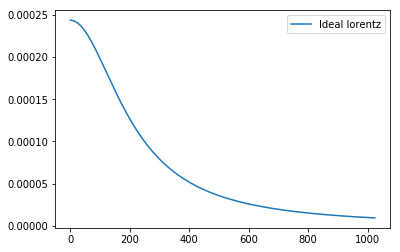

In [9]:
%matplotlib inline

simulator = Simulator()
simulator.configure_experiment()

N_f = 2**12
f_max = 2**10

freqs = np.linspace(0, f_max, N_f)
ideal_lorentz = simulator.get_lorentz(100e-9, freqs)

fig, ax = plt.subplots()
ax.plot(freqs, ideal_lorentz, label='Ideal lorentz')
plt.legend()

# Experimental Lorentz Generation

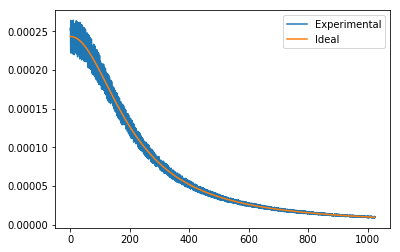

In [94]:
noise_level = 0.1

exp_lorentz = np.array(list(map(lambda x: x * (1 + np.random.uniform(-noise_level, noise_level)), ideal_lorentz)))

fig, ax = plt.subplots()
ax.plot(freqs, exp_lorentz, label='Experimental')
ax.plot(freqs, ideal_lorentz, label='Ideal')
plt.legend()

# WRIM 

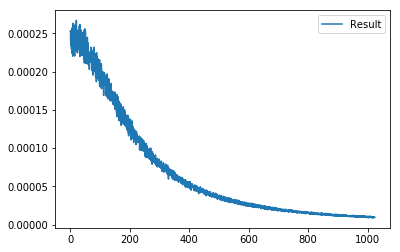

In [162]:
%matplotlib inline
import pywt
import numpy as np
import seaborn
import pandas as pd
from statsmodels.robust import mad
def wrim(signal, level=0, wavelet='db1'):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( signal, wavelet, mode="per", level=level)
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( signal) ) ) 
    coeff[1:] = ( pywt.threshold( i, value=uthresh/100000000, mode='greater' ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet)
    
    return y

result_lorentz = wrim(exp_lorentz, level=4)

fig, ax = plt.subplots()
ax.plot(freqs, result_lorentz, label='Result')
#ax.plot(freqs, exp_lorentz, label='Experiment')
plt.legend()

# Main Study 

1e-09 2e-06
65.40784898479336
1e-09 2e-06
65.40784898479336


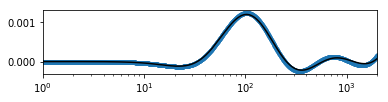

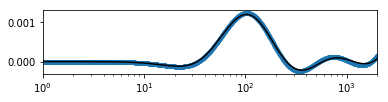

In [151]:
m = 2 # depth of decomposition 
count = 1 # iterator
coeff = simulator.coeff

# Initial interval
d_min = 1e-9 # 1 нм
d_max = 2000e-9

# задаем сетку по Gamma
G_min = coeff/d_max
G_max = coeff/d_min
N = 256*8 # Число узлов в сетке по \Gamma
M = len(freqs) # Число точек по частоте
p = (G_max/G_min)**(1/(N-1))
G = np.zeros(N)

# неравнмерная сетка со сгущением к нулю (так как больщий вклад в интенсивность дают крупные частицы)
# хотя такая сетка - это не единственно возможный вариант
for j in range(N):
    G[j] = G_min * (p**j)

A = np.zeros((M,N))

# Матрица коэффициентов (составляется по базисным ф-ям)
for i in range(M):
    for j in range(N):
        A[i,j] = G[j] / ((2 * np.pi * freqs[i])**2 + G[j]**2)
diam_poss = pd.DataFrame(columns=['d', 'p'])
lorentz = exp_lorentz

while count <= m:
    new_lorentz = wrim(lorentz, count)
    clf = sklm.Ridge(alpha = 5e-5)
    clf.fit(A, new_lorentz)
    a1 = clf.coef_
    
    clf.fit(A, ideal_lorentz)
    a2 = clf.coef_

    fig = plt.figure()
    ax = plt.subplot(3, 1, 1)
    line,  = plt.plot(1e+9 * coeff/G, a1,'.-')
    line_, = plt.plot(1e+9 * coeff/G, a2, color='black')
    ax.set_xscale('log')
    plt.xlim(1, 2000)
    
    lorentz = new_lorentz
    diam_poss['d'] = 1e+9 * coeff/G
    diam_poss['p'] = a1
    count += 1 
    threshold = diam_poss['d'][diam_poss['p'] == diam_poss['p'].max()].values[0] / 2
    #d_min = search_first_zero(diam_poss)[0]
    #d_max = search_first_zero(diam_poss)[1]
    print(d_min, d_max)
    # задаем сетку по Gamma
    G_min = coeff/d_max
    print(G_min)
    G_max = coeff/d_min
    N = 256*8 # Число узлов в сетке по \Gamma
    M = len(freqs) # Число точек по частоте
    p = (G_max/G_min)**(1/(N-1))
    G = np.zeros(N)

    for j in range(N):
        G[j] = G_min * (p**j)

    # вот равномерная сетка
    #G = np.linspace(G_min, G_max, N)    

    A = np.zeros((M,N))

    # Матрица коэффициентов (составляется по базисным ф-ям)
    for i in range(M):
        for j in range(N):
            A[i,j] = G[j] / ((2 * np.pi * freqs[i])**2 + G[j]**2)

In [152]:
def search_first_zero(data):
    d_max_p       = data[data['p'] == data['p'].max()]['d'].max()
    d_max_p_index = data[data['p'] == data['p'].max()].index[0]
    df_1 = data[:d_max_p_index]
    df_2 = data[d_max_p_index:]
    
    d_max = df_1[df_1['p'] < 0.01].tail(1)['d'].values[0] * 1e-9
    d_min = df_2[df_2['p'] < 0.01].head(1)['d'].values[0] * 1e-9
    return [d_min, d_max]